In [2]:
%matplotlib inline

In [35]:
from libcomcat.search import get_event_by_id
from libcomcat.dataframes import get_pager_data_frame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import time
from scipy.optimize import curve_fit
from IPython.display import display

Working with tabular data in Python generally means working with the [pandas](https://pandas.pydata.org/) library. For the purposes of this discussion, pandas provides two useful data structures: A Series object (analogous to a dictionary), and a DataFrame object, which is analogous to an Excel spreadsheet, from which columns or rows can be extracted as Series objects.

DataFrames can be read in from delimited (comma, tab, etc.) text files, Excel files, database tables, or created from scratch. DataFrame objects provide a number of useful methods for data exploration and analysis including:

 - computation
 - statistics
 - plotting
 
In this notebook, we'll be reading, "cleaning", and exploring one data set.
 
## Contents
----
- [Reading Delimited Data](#Reading-Delimited-Data)
- [Cleaning Data](#Cleaning-Data)
  - [Indexing and Selecting](#Indexing-and-Selecting)
  - [Fixing Columns](#Fixing-Columns)
  - [Extracting Data From Columns](#Extracting-Data-From-Columns)
  - [Subsetting Data](#Subsetting-Data)
  - [Removing Duplicates](#Removing-Duplicates)
  - [Merging DataFrames](#Merging-DataFrames)
- [Exploring Data](#Exploring-Data)
  - [Comparing Observed and Predicted](#Comparing-Observed-and-Predicted)

## Reading Delimited Data

pandas can read data from a number of formats:

 - Comma* separated values (CSV)
 - Excel spreadsheets
 - Hierarchical Data Format (HDF) file
 - Relational databases
 
\*For reading CSV files, pandas provides a function called *read_csv()*. Despite its name, this function is not limited to reading text files with columns separated by commas. The delimiter can be just about anything - tabs are very common, as are pipes ("|"), as we see below. 



This data set is extracted from the Hydra QA database, and represents USGS National Earthquake Information Center (NEIC) analyst reports collected on earthquake impacts. There are a few things to note about this file that we will have to deal with before doing any analysis with it. This is known as "data cleaning".

 - As noted above the delimiter is a "|" character.
 - There are spaces around the column names
 - The last three lines of the file do not match the format in the rest of the file
 - Most of the data of interest is contained in the "spassportentry" column, and consists of columns separated by whitespace.

I've written two functions below that allow us to quickly see the beginning and ending lines of a file, similar to the *head* and *tail* commands available on OSX and Linux.

In [4]:
def head(filename, nlines):
    with open(filename, 'rt') as f:
        for i in range(0,nlines):
            print('*'+f.readline()+'*')

In [5]:
def tail(filename, nlines):
    lines = open(filename, 'rt').readlines()
    for i in range(-nlines,-1):
        print('*'+lines[i]+'*')

In [6]:
impact_file = '../data/hydra_impact_comments.txt'
head(impact_file,5)

* huidevent |         ot          |  mag  |   spassportcmd    |                                                                                                                                                                                                                                                 spassportentry                                                                                                                                                                                                                                                 
*
* C0004KTB  | 2011/06/29 23:16:39 | 4.925 | PubFlagsAddImpact | Injuries Shaking Exact 7 0 "http://www.huffingtonpost.com/2011/06/29/japan-earthquake-central_n_887535.html" 1309305961 ""
*
* C0005IDZ  | 2011/08/23 05:46:18 | 5.269 | PubFlagsAddImpact | Damaged Shaking Few 0 0 "" 1317972203 "(VII) Segundo, (VI) Cokedale and Valdez and (V) Trinidad"
*
* C0005WX9  | 2011/09/19 18:33:59 | 5.801 | PubFlagsAddImpact | Deaths Shaking Exact 1

In [7]:
tail(impact_file,3)

* C000773I  |                     |   2.2 | PubFlagsAddImpact | Injuries Shaking Exact 7 0 "" 1324341637 ""
*
*(2439 rows)
*


You can look at the documentation for read_csv [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), or by executing "pd.read_csv?" in a code cell.

Note that there are several options we can use to help ourselves out right off the bat:

 - the *parse_dates* option will allow us to read in the "ot" (origin time) column as a pandas Timestamp *object*, not just a string.
 - While we could read in the columns from the file and then fix the extra spaces, it's easier to use the *skiprows* option to skip the first line, and allow us to provide our own column names.
 - We can use the *skipfooter* option to ignore those final three problematic lines.

In [8]:
columns = ['hydra_id', 'hydra_time', 'hydra_magnitude', 'hydra_command', 'passport_entry']
hydra_impacts = pd.read_csv(impact_file, names=columns, engine='python',
                            parse_dates=['hydra_time'], skiprows=1, 
                            skipfooter=3, delimiter='|')
hydra_impacts.head()

,hydra_id,hydra_time,hydra_magnitude,hydra_command,passport_entry
0,C0004KTB,2011-06-29 23:16:39,4.925,PubFlagsAddImpact,"Injuries Shaking Exact 7 0 ""http://www.huffin..."
1,C0005IDZ,2011-08-23 05:46:18,5.269,PubFlagsAddImpact,"Damaged Shaking Few 0 0 """" 1317972203 ""(VII) ..."
2,C0005WX9,2011-09-19 18:33:59,5.801,PubFlagsAddImpact,"Deaths Shaking Exact 1 0 ""AP from Guatemala C..."
3,C0005WX9,2011-09-19 18:33:59,5.801,PubFlagsAddImpact,"Injuries Shaking Some 0 0 ""AP from Guatemala ..."
4,C0007NLY,2012-01-19 12:35:52,5.105,PubFlagsAddImpact,"Injuries Unknown AtLeast 200 0 """" 1327037928 """""


Let's confirm that our timestamp parsing worked, by asking a question about *duration* of the data set.

In [9]:
hydra_impacts['hydra_time'].max() - hydra_impacts['hydra_time'].min()

Timedelta('3279 days 23:24:14')

## Cleaning Data

### Fixing Columns
Next, let's convert that hydra ID to a ComCat-compatible event ID by prepending 'us' to each ID, and lowercasing the column while we're at it. Fortunately, pandas provides a number of string methods that can operate on all elements of an array (column, row, etc.) These are well-described [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html#string-methods). Many of these functions should be familiar to anyone who has used the methods of the standard Python *str* object. 

It turns out that some of these hydra_id values have extraneous spaces in them as well. You can chain multiple string operations together, as seen below with lower() and strip(). 

Finally, it turns out that there are [multiple ways](https://stackoverflow.com/questions/20025882/add-a-string-prefix-to-each-value-in-a-string-column-using-pandas) to prepend a string to the values in a column. Once again StackOverflow comes to the rescue. This was the most syntactically straighforward solution.

In [10]:
hydra_impacts['hydra_id'] = hydra_impacts['hydra_id'].str.lower().str.strip()
hydra_impacts['hydra_command'] = hydra_impacts['hydra_command'].str.strip()
hydra_impacts['hydra_id'] = 'us' + hydra_impacts['hydra_id'].astype(str)
hydra_impacts.head()

,hydra_id,hydra_time,hydra_magnitude,hydra_command,passport_entry
0,usc0004ktb,2011-06-29 23:16:39,4.925,PubFlagsAddImpact,"Injuries Shaking Exact 7 0 ""http://www.huffin..."
1,usc0005idz,2011-08-23 05:46:18,5.269,PubFlagsAddImpact,"Damaged Shaking Few 0 0 """" 1317972203 ""(VII) ..."
2,usc0005wx9,2011-09-19 18:33:59,5.801,PubFlagsAddImpact,"Deaths Shaking Exact 1 0 ""AP from Guatemala C..."
3,usc0005wx9,2011-09-19 18:33:59,5.801,PubFlagsAddImpact,"Injuries Shaking Some 0 0 ""AP from Guatemala ..."
4,usc0007nly,2012-01-19 12:35:52,5.105,PubFlagsAddImpact,"Injuries Unknown AtLeast 200 0 """" 1327037928 """""


In this context, seeing magnitude reported beyond 1 significant digit is not useful. Let's round those values to the nearest tenth of a magnitude unit.

In [11]:
hydra_impacts['hydra_magnitude'] = hydra_impacts['hydra_magnitude'].round(decimals=1)
hydra_impacts.head()

,hydra_id,hydra_time,hydra_magnitude,hydra_command,passport_entry
0,usc0004ktb,2011-06-29 23:16:39,4.9,PubFlagsAddImpact,"Injuries Shaking Exact 7 0 ""http://www.huffin..."
1,usc0005idz,2011-08-23 05:46:18,5.3,PubFlagsAddImpact,"Damaged Shaking Few 0 0 """" 1317972203 ""(VII) ..."
2,usc0005wx9,2011-09-19 18:33:59,5.8,PubFlagsAddImpact,"Deaths Shaking Exact 1 0 ""AP from Guatemala C..."
3,usc0005wx9,2011-09-19 18:33:59,5.8,PubFlagsAddImpact,"Injuries Shaking Some 0 0 ""AP from Guatemala ..."
4,usc0007nly,2012-01-19 12:35:52,5.1,PubFlagsAddImpact,"Injuries Unknown AtLeast 200 0 """" 1327037928 """""


### Indexing and Selecting

You may be wondering at this point what the unlabeled column at the left of our DataFrame is for. This is an *index* column, and the values in it are used as labels for the rows. By default, pandas assigns integer labels for the index, but this index could be any kind of variable. In our situation, the most logical candidate for an index is the hydra_id.

In [24]:
tmp_impacts = hydra_impacts.set_index('hydra_id')
tmp_impacts.head()

,hydra_time,hydra_magnitude,hydra_command,passport_entry
hydra_id,,,,
usc0004ktb,2011-06-29 23:16:39,4.9,PubFlagsAddImpact,"Injuries Shaking Exact 7 0 ""http://www.huffin..."
usc0005idz,2011-08-23 05:46:18,5.3,PubFlagsAddImpact,"Damaged Shaking Few 0 0 """" 1317972203 ""(VII) ..."
usc0005wx9,2011-09-19 18:33:59,5.8,PubFlagsAddImpact,"Deaths Shaking Exact 1 0 ""AP from Guatemala C..."
usc0005wx9,2011-09-19 18:33:59,5.8,PubFlagsAddImpact,"Injuries Shaking Some 0 0 ""AP from Guatemala ..."
usc0007nly,2012-01-19 12:35:52,5.1,PubFlagsAddImpact,"Injuries Unknown AtLeast 200 0 """" 1327037928 """""


In [71]:
# selecting single event by label (.loc) # this returns a series
tmp_impacts.loc['usc0004ktb']

hydra_time                                       2011-06-29 23:16:39
hydra_magnitude                                                  4.9
hydra_command                                      PubFlagsAddImpact
passport_entry      Injuries Shaking Exact 7 0 "http://www.huffin...
Name: usc0004ktb, dtype: object

In [65]:
# selecting multiple events by label (.loc)
tmp_impacts.loc[['usc0004ktb','usc0005idz']]

,hydra_time,hydra_magnitude,hydra_command,passport_entry
hydra_id,,,,
usc0004ktb,2011-06-29 23:16:39,4.9,PubFlagsAddImpact,"Injuries Shaking Exact 7 0 ""http://www.huffin..."
usc0005idz,2011-08-23 05:46:18,5.3,PubFlagsAddImpact,"Damaged Shaking Few 0 0 """" 1317972203 ""(VII) ..."


In [66]:
# selecting a column from multiple events 
tmp_impacts.loc[['usc0004ktb','usc0005idz'],'passport_entry']

hydra_id
usc0004ktb     Injuries Shaking Exact 7 0 "http://www.huffin...
usc0005idz     Damaged Shaking Few 0 0 "" 1317972203 "(VII) ...
Name: passport_entry, dtype: object

In [67]:
# selecting multiple events by position
tmp_impacts.iloc[0:2]

,hydra_time,hydra_magnitude,hydra_command,passport_entry
hydra_id,,,,
usc0004ktb,2011-06-29 23:16:39,4.9,PubFlagsAddImpact,"Injuries Shaking Exact 7 0 ""http://www.huffin..."
usc0005idz,2011-08-23 05:46:18,5.3,PubFlagsAddImpact,"Damaged Shaking Few 0 0 """" 1317972203 ""(VII) ..."


In [72]:
# selecting single row by position
tmp_impacts.iloc[0]

hydra_time                                       2011-06-29 23:16:39
hydra_magnitude                                                  4.9
hydra_command                                      PubFlagsAddImpact
passport_entry      Injuries Shaking Exact 7 0 "http://www.huffin...
Name: usc0004ktb, dtype: object

In [70]:
# selecting by row and column positions
tmp_impacts.iloc[0:2,[1,3]]

,hydra_magnitude,passport_entry
hydra_id,,
usc0004ktb,4.9,"Injuries Shaking Exact 7 0 ""http://www.huffin..."
usc0005idz,5.3,"Damaged Shaking Few 0 0 """" 1317972203 ""(VII) ..."


One of the most common use cases in our experience, however, is sub-selecting a DataFrame based on criteria in one of more colums. 

If you recall from numpy, you select elements of an array most efficiently by doing:

```
x = np.arange(1,6) # returns: array([1, 2, 3, 4, 5])
x > 3 # returns: array([False, False, False,  True,  True], dtype=bool)
x[x > 3] # returns: array([4, 5])
```

The same sort of selection syntax is possible in pandas:

In [77]:
tmp_impacts[tmp_impacts['hydra_time'] > pd.Timestamp('2020-06-01')]

,hydra_time,hydra_magnitude,hydra_command,passport_entry
hydra_id,,,,
us6000a4yi,2020-06-03 07:35:36,6.8,PubFlagsAddImpact,"Damaged Unknown Unknown 0 0 ""https://www.diar..."
us6000a5jq,2020-06-03 22:30:55,4.6,PubFlagsAddImpact,"Damaged Shaking Some 0 0 ""wikipedia"" 15913040..."
us6000a6qw,2020-06-05 18:06:22,5.2,PubFlagsAddImpact,"Damaged Unknown AtLeast 20 0 ""*NULL*"" 1591948..."
us6000a7ea,2020-06-07 05:27:23,4.5,PubFlagsAddImpact,"Deaths HeartAttack Exact 1 0 ""diario correo"" ..."
us6000abnv,2020-06-14 14:24:29,5.9,PubFlagsAddImpact,"Injuries Shaking Exact 9 0 ""*NULL*"" 159221765..."
us6000abnv,2020-06-14 14:24:29,5.9,PubFlagsAddImpact,"Damaged Shaking Some 0 0 ""*NULL*"" 1592217712 ..."
us6000abnv,2020-06-14 14:24:29,5.9,PubFlagsAddImpact,"Deaths Shaking Exact 1 0 ""https://news.trust...."
us6000ag4u,2020-06-21 22:40:53,5.6,PubFlagsAddImpact,"Damaged Shaking Some 0 0 ""Wikipedia"" 15928575..."


You can also make complex selections - for example, we might want to see all events in 2019 that are greater than M6.0. If you have multiple selection criteria, you can split those criteria into different arrays and combine them with boolean operators.

In [88]:
start_2019 = tmp_impacts['hydra_time'] > pd.Timestamp('2019-01-01')
end_2019 = tmp_impacts['hydra_time'] > pd.Timestamp('2019-12-31 23:59:59')
mag_6plus = tmp_impacts['hydra_magnitude'] > 6.0
tmp_impacts[start_2019 & end_2019 & mag_6plus].head()

,hydra_time,hydra_magnitude,hydra_command,passport_entry
hydra_id,,,,
us70006vkq,2020-01-07 06:05:20,6.3,PubFlagsAddImpact,"Damaged Unknown Some 0 0 ""https://www.nytimes..."
us70006vll,2020-01-07 08:24:25,6.4,PubFlagsAddImpact,"Injuries Unknown Exact 8 0 ""*NULL*"" 157855462..."
us70006vll,2020-01-07 08:24:25,6.4,PubFlagsAddImpact,"Deaths Unknown Exact 1 0 ""*NULL*"" 1578554550 ..."
us70006vll,2020-01-07 08:24:25,6.4,PubFlagsAddImpact,"DollarLoss Unknown Estimate 310000000 0 ""*NUL..."
us70006vll,2020-01-07 08:24:25,6.4,PubFlagsDelImpact,"DollarLoss Unknown Estimate 310000000 0 ""*NUL..."


### Extracting Data From Columns
Now for the hard part - we need to parse the impact data out of the passport_entry column. To handle this, we'll need to iterate over the rows of the dataframe, pull apart the passport_entry column, and create a new DataFrame. You can construct new DataFrame objects in a number of different ways - we'll create a list of Series objects and pass that to the constructor.

In [12]:
IMPACT_COLUMNS = ['LossExtent',
                  'EffectType',
                  'LossQuantifier',
                  'LossValue',
                  'Location',
                  'CollectionSource',
                  'database_id',
                  'comment']
rows = []
for idx, hydra_row in hydra_impacts.iterrows():
    passport_parts = hydra_row['passport_entry'].split()
    # make a dictionary out of the passport entry
    pdict = dict(zip(IMPACT_COLUMNS, passport_parts))
    new_row_dict = hydra_row.to_dict()
    new_row_dict.update(pdict)
    rows.append(new_row_dict)
    
impacts = pd.DataFrame(rows)
# we need to change the data type of the LossValue column to an integer
impacts['LossValue'] = impacts['LossValue'].astype(np.int32)
impacts.head()

,hydra_id,hydra_time,hydra_magnitude,hydra_command,passport_entry,LossExtent,EffectType,LossQuantifier,LossValue,Location,CollectionSource,database_id,comment
0,usc0004ktb,2011-06-29 23:16:39,4.9,PubFlagsAddImpact,"Injuries Shaking Exact 7 0 ""http://www.huffin...",Injuries,Shaking,Exact,7,0,"""http://www.huffingtonpost.com/2011/06/29/japa...",1309305961,""""""
1,usc0005idz,2011-08-23 05:46:18,5.3,PubFlagsAddImpact,"Damaged Shaking Few 0 0 """" 1317972203 ""(VII) ...",Damaged,Shaking,Few,0,0,"""""",1317972203,"""(VII)"
2,usc0005wx9,2011-09-19 18:33:59,5.8,PubFlagsAddImpact,"Deaths Shaking Exact 1 0 ""AP from Guatemala C...",Deaths,Shaking,Exact,1,0,"""AP",from,Guatemala
3,usc0005wx9,2011-09-19 18:33:59,5.8,PubFlagsAddImpact,"Injuries Shaking Some 0 0 ""AP from Guatemala ...",Injuries,Shaking,Some,0,0,"""AP",from,Guatemala
4,usc0007nly,2012-01-19 12:35:52,5.1,PubFlagsAddImpact,"Injuries Unknown AtLeast 200 0 """" 1327037928 """"",Injuries,Unknown,AtLeast,200,0,"""""",1327037928,""""""


We don't need the passport_entry column anymore, so we use the *drop* method to get rid of it.

In [13]:
impacts.drop('passport_entry', axis='columns', inplace=True)
impacts.head()

,hydra_id,hydra_time,hydra_magnitude,hydra_command,LossExtent,EffectType,LossQuantifier,LossValue,Location,CollectionSource,database_id,comment
0,usc0004ktb,2011-06-29 23:16:39,4.9,PubFlagsAddImpact,Injuries,Shaking,Exact,7,0,"""http://www.huffingtonpost.com/2011/06/29/japa...",1309305961,""""""
1,usc0005idz,2011-08-23 05:46:18,5.3,PubFlagsAddImpact,Damaged,Shaking,Few,0,0,"""""",1317972203,"""(VII)"
2,usc0005wx9,2011-09-19 18:33:59,5.8,PubFlagsAddImpact,Deaths,Shaking,Exact,1,0,"""AP",from,Guatemala
3,usc0005wx9,2011-09-19 18:33:59,5.8,PubFlagsAddImpact,Injuries,Shaking,Some,0,0,"""AP",from,Guatemala
4,usc0007nly,2012-01-19 12:35:52,5.1,PubFlagsAddImpact,Injuries,Unknown,AtLeast,200,0,"""""",1327037928,""""""


### Subsetting Data
Because we're only interested in fatalities due to shaking for the purpose of this analysis, let's extract just those rows.

In [14]:
condition1 = impacts['LossExtent'] == 'Deaths'
condition2 = impacts['EffectType'] == 'Shaking'
condition3 = impacts['hydra_command'] == 'PubFlagsAddImpact'
deaths = impacts[condition1 & condition2 & condition3]
deaths.head()

,hydra_id,hydra_time,hydra_magnitude,hydra_command,LossExtent,EffectType,LossQuantifier,LossValue,Location,CollectionSource,database_id,comment
2,usc0005wx9,2011-09-19 18:33:59,5.8,PubFlagsAddImpact,Deaths,Shaking,Exact,1,0,"""AP",from,Guatemala
65,usb000dlwm,2012-11-07 16:35:48,7.4,PubFlagsAddImpact,Deaths,Shaking,AtLeast,30,0,"""CNNEspanol""",1352339793,"""*NULL*"""
66,usb000dlwm,2012-11-07 16:35:48,7.4,PubFlagsAddImpact,Deaths,Shaking,AtLeast,30,0,"""CNNEspanol""",1352339793,"""*NULL*"""
69,usc000dqqw,2012-11-11 01:12:38,6.8,PubFlagsAddImpact,Deaths,Shaking,AtLeast,12,0,"""*NULL*""",1352651004,"""*NULL*"""
72,usc000dqqw,2012-11-11 01:12:38,6.8,PubFlagsAddImpact,Deaths,Shaking,AtLeast,26,0,"""*NULL*""",1352651004,"""*NULL*"""


### Removing Duplicates

You may notice that we have multiple fatality entries for some events. If this were a *true* analysis, we would do something clever and appropriate to determine the correct number of fatalities. Here we'll just choose the maximum value for each event, using an answer found from [StackOverflow](https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-count-in-groups-using-groupby)*. We'll also re-sort the data in time ascending order once we're finishing removing duplicates.

*Google and stack overflow are going to be your friends.

In [15]:
#idx = deaths.groupby(['hydra_id'])['LossValue'].transform(max) == deaths['LossValue']
#newdeaths = deaths[idx]
newdeaths = deaths.sort_values('LossValue', ascending=False).drop_duplicates(['hydra_id'])
newdeaths.sort_values('hydra_time', inplace=True)
newdeaths.head()

,hydra_id,hydra_time,hydra_magnitude,hydra_command,LossExtent,EffectType,LossQuantifier,LossValue,Location,CollectionSource,database_id,comment
2,usc0005wx9,2011-09-19 18:33:59,5.8,PubFlagsAddImpact,Deaths,Shaking,Exact,1,0,"""AP",from,Guatemala
65,usb000dlwm,2012-11-07 16:35:48,7.4,PubFlagsAddImpact,Deaths,Shaking,AtLeast,30,0,"""CNNEspanol""",1352339793,"""*NULL*"""
72,usc000dqqw,2012-11-11 01:12:38,6.8,PubFlagsAddImpact,Deaths,Shaking,AtLeast,26,0,"""*NULL*""",1352651004,"""*NULL*"""
95,usb000ftgc,2013-03-27 02:03:21,5.9,PubFlagsAddImpact,Deaths,Shaking,Exact,1,0,"""*NULL*""",1365389149,"""*NULL*"""
104,usb000g2y5,2013-04-09 11:52:50,6.2,PubFlagsAddImpact,Deaths,Shaking,AtLeast,69,0,"""http://www.ncr-iran.org/en/news/society/13385...",1365482143,"""*NULL*"""


### Merging DataFrames

Let's say we want to compare these *observed* fatalities with the *predicted* fatalities from PAGER. We can extract those fatalities from ComCat using the libcomcat tools. It takes about 90 seconds to download this data, so we'll load it from a pre-fetched file here.

In [16]:
expframe = pd.read_csv('../data/pager_exposures_hydra.csv')
expframe.head()

,hydra_id,eventid,time,latitude,longitude,depth,magnitude,predicted_deaths,mmi5,mmi6,mmi7,mmi8,mmi9,mmi10
0,usb000ftgc,usb000ftgc,2013-03-27 02:03:19.820,23.828,121.2150,19.0,5.9,0.0,3338987,152641,0,0,0,0
1,usb000g2y5,usb000g2y5,2013-04-09 11:52:49.920,28.428,51.5930,12.0,6.4,0.0,294549,64280,18738,4037,0,0
2,usb000g7x7,usb000g7x7,2013-04-16 10:44:20.180,28.033,61.9960,80.0,7.7,0.0,898058,426542,27629,0,0,0
3,usb000i4re,usb000i4re,2013-07-02 07:37:02.610,4.645,96.6650,13.0,6.1,0.0,321142,80861,26430,17,0,0
4,usb000jyiv,usb000jyiv,2013-09-24 11:29:47.970,26.951,65.5009,15.0,7.7,0.0,10192628,550456,75454,70640,6109,0


If you want to run the cell below, note that you'll be overriding the DataFrame *expframe* we read in above. Even if you don't run this cell, you should examine it carefully to notice some new things:

 - We are iterating over rows using the DataFrame *iterrows()* method, which returns the index and a reference to the Series representing the row of data.
 - We are also using two functions from the libcomcat library:
   - *get_event_by_id()* - This returns a DetailEvent object, from which you can extract *authoritative* event information.
   - *get_pager_data_frame()* This returns (in this case) a DataFrame with one row of PAGER exposure/loss information, or None if no PAGER results were created for the event.
 - We're also demonstrating the use of the DataFrame *to_csv()* method. Saving DataFrames to CSV or Excel is pretty straightforward, so we'll just point users to the documentation for [to_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) and [to_excel](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_excel.html#pandas.DataFrame.to_excel)
 
#### To re-create the *expframe* variable:

 - Change the type of the cell below from "Markdown" to "Code"
 - Remove the leading/trailing triple backticks \`\`\`
 - Execute the cell

```
# ---------------------------------------------------------
exprows = []
t1 = time.time()
for idx, row in newdeaths.iterrows():
    detail = get_event_by_id(row['hydra_id'])
    expdict = {}
    # fill in columns with ComCat authoritative values
    expdict['hydra_id'] = row['hydra_id']
    expdict['eventid'] = detail.id
    expdict['time'] = pd.to_datetime(detail.time)
    expdict['latitude'] = detail.latitude
    expdict['longitude'] = detail.longitude
    expdict['depth'] = detail.depth
    expdict['magnitude'] = detail.magnitude
    
    # now retrieve the PAGER exposure data for this event
    expframe = get_pager_data_frame(detail, get_losses=True)
    if expframe is None:
        msg = (f"event {row['hydra_id']} "
               f"Date: {row['hydra_time']} "
               f"Magnitude: {row['hydra_magnitude']}")
        print(f'No PAGER information found for {msg}. Skipping.')
        continue
    exprow = expframe.iloc[0]
    expdict['predicted_deaths'] = exprow['predicted_fatalities']
    expdict['mmi5'] = exprow['mmi5']
    expdict['mmi6'] = exprow['mmi6']
    expdict['mmi7'] = exprow['mmi7']
    expdict['mmi8'] = exprow['mmi8']
    expdict['mmi9'] = exprow['mmi9']
    expdict['mmi10'] = exprow['mmi10']
    exprows.append(expdict)
expframe = pd.DataFrame(exprows)
t2 = time.time()
print(f'Elapsed time: {t2-t1:.1f} seconds')
expframe.head()
expframe.to_csv('../data/pager_exposures_hydra.csv', index=False)
# ---------------------------------------------------------
```

Now we need to merge the *observed* fatality dataframe we've created with the *predicted* fatality/exposure dataset we've extracted from ComCat. pandas DataFrame objects provide us with the *merge* method, which is described in detail [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html).

In [18]:
expdeaths = newdeaths.merge(expframe, on='hydra_id')
expdeaths.head()

,hydra_id,hydra_time,hydra_magnitude,hydra_command,LossExtent,EffectType,LossQuantifier,LossValue,Location,CollectionSource,...,longitude,depth,magnitude,predicted_deaths,mmi5,mmi6,mmi7,mmi8,mmi9,mmi10
0,usb000ftgc,2013-03-27 02:03:21,5.9,PubFlagsAddImpact,Deaths,Shaking,Exact,1,0,"""*NULL*""",...,121.2150,19.0,5.9,0.0,3338987,152641,0,0,0,0
1,usb000g2y5,2013-04-09 11:52:50,6.2,PubFlagsAddImpact,Deaths,Shaking,AtLeast,69,0,"""http://www.ncr-iran.org/en/news/society/13385...",...,51.5930,12.0,6.4,0.0,294549,64280,18738,4037,0,0
2,usb000g7x7,2013-04-16 10:44:20,7.8,PubFlagsAddImpact,Deaths,Shaking,AtLeast,40,0,"""*NULL*""",...,61.9960,80.0,7.7,0.0,898058,426542,27629,0,0,0
3,usb000i4re,2013-07-02 07:37:03,6.0,PubFlagsAddImpact,Deaths,Shaking,Estimate,42,0,"""*NULL*""",...,96.6650,13.0,6.1,0.0,321142,80861,26430,17,0,0
4,usb000jyiv,2013-09-24 11:29:48,7.7,PubFlagsAddImpact,Deaths,Shaking,AtLeast,825,0,"""http://www.nation.com.pk/""",...,65.5009,15.0,7.7,0.0,10192628,550456,75454,70640,6109,0


## Exploring Data

### Comparing Observed and Predicted

We can now inspect the resulting DataFrame and see that we have all of the columns from both input DataFrames. At this point, the data has been effectively cleaned, and we can begin doing some simple data exploration and analysis.

The PAGER project calculates estimated fatalities for an event based on a ShakeMap input and country-specific loss models. When we want to get a visual sense of how the models are performing compared to observations of fatalities, it is useful to compare them within the ranges defined for PAGER alert levels, which are:

 - Green: 0 fatalities (no response needed)
 - Yellow: 1-99 fatalities (local/regional response)
 - Orange: 100-999 fatalities (national response)
 - Red: 1000+ fatalities (international response)
 
Our assumption is, for example, that the ground *response* to an earthquake with 25 fatalities will be about the same as one with 50 fatalities. So, we make a figure that demonstrates how often our predictions fall within the observed range, as with the plot below.

#### Sidebar: "A value is trying to be set on a copy of a slice from a DataFrame"

You may see this excessively passive voice error coming from pandas at some point, and wonder what the heck it means. 

When using pandas indexing to select a row or column from a DataFrame, what you get back is a *reference* to the same data that is in the original DataFrame. If you then try to *modify* this extracted row or column, you'll get the above error, along with a link to [this page](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy).

A well-written page describing what's going on here, and how to solve it:

[https://www.dataquest.io/blog/settingwithcopywarning/](https://www.dataquest.io/blog/settingwithcopywarning/)

We bring this up here because of the following lines of code in the cell below:

```
observed = expdeaths['LossValue'].to_numpy()
predicted = expdeaths['predicted_deaths'].to_numpy()
observed[observed == 0] = 0.01
predicted[predicted == 0] = 0.01
```

Adding the *to_numpy()* method to convert the observed and predicted fatality columns to numpy arrays explicitly makes copies of those two columns, thus avoiding the warning and doing (in this case) what we want.

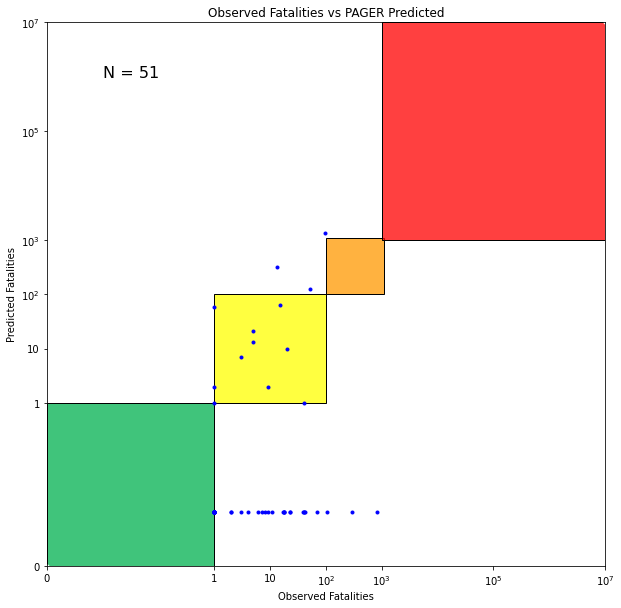

In [22]:
ALPHA = 0.75
GREEN = (0/255,176/255,79/255,ALPHA)
YELLOW = (255/255,255/255,0/255,ALPHA)
ORANGE = (255/255,153/255,0/255,ALPHA)
RED = (255/255,0/255,0/255,ALPHA)
fig = plt.figure(figsize=(10,10));
plt.loglog([0.001,1e7], [0.001,1e7],'w.');
ax = fig.axes[0]
errorboxes = []
rgreen = Rectangle((0.001,0.001),1,1, facecolor=GREEN, edgecolor='black');
ryellow = Rectangle((1,1),100,100, facecolor=YELLOW, edgecolor='black');
rorange = Rectangle((100,100),1000,1000, facecolor=ORANGE, edgecolor='black');
rred = Rectangle((1000,1000),1e7,1e7, facecolor=RED, edgecolor='black');
ax.add_patch(rgreen);
ax.add_patch(ryellow);
ax.add_patch(rorange);
ax.add_patch(rred);
observed = expdeaths['LossValue'].to_numpy()
predicted = expdeaths['predicted_deaths'].to_numpy()
observed[observed == 0] = 0.01
predicted[predicted == 0] = 0.01
plt.loglog(observed, predicted, 'b.');
xlocs, _ = plt.xticks();
ylocs, _ = plt.yticks();
xlocs = [0.001, 1, 10, 100, 1000, 1e5, 1e7]
ylocs = [0.001, 1, 10, 100, 1000, 1e5, 1e7]
newlabels = ['0', '1', '10', '$10^2$', '$10^3$', '$10^5$', '$10^7$']
plt.xticks(xlocs, newlabels);
plt.yticks(ylocs, newlabels);
plt.axis([0.001,1e7, 0.001, 1e7]);
plt.title('Observed Fatalities vs PAGER Predicted');
plt.text(0.01, 1e6,f'N = {len(predicted)}', fontsize=16);
plt.xlabel('Observed Fatalities');
plt.ylabel('Predicted Fatalities');

*NB: Note here that our sample size is only 51 events, so take this "analysis" with a grain of salt.*

You could possibly infer from the above plot that the PAGER system may:
 - underpredict events that have 0 observed fatalities
 - do a reasonable job at predicting "Yellow" alert events
 - overpredict events in the "Orange" alert range